In [1]:
import geopandas as gpd
from geopandas import GeoDataFrame
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.path as path
import matplotlib.pyplot as plt
from shapely.geometry import Point
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

In [2]:
wards = gpd.read_file('Datasets/shapefiles/London_Ward_CityMerged.shp')
imd = pd.read_csv('Datasets/IMD 2019.csv')
crime = pd.read_csv('Datasets/Ward Data.csv')
ward_feats = pd.read_csv('Datasets/ward_profile.csv')

In [3]:
print('Ward shp: %s | imd wards: %s | crime wards: %s | features: %s'%
      (len(wards), len(imd),len( crime[crime['Month-Year'] == 'Apr 2020']), len(ward_feats)))

Ward shp: 633 | imd wards: 1048574 | crime wards: 632 | features: 660


In [4]:
wards.head()

,NAME,GSS_CODE,DISTRICT,LAGSSCODE,HECTARES,NONLD_AREA,geometry
0,Chessington South,E05000405,Kingston upon Thames,E09000021,755.173,0.0,"POLYGON ((516401.596 160201.802, 516407.302 16..."
1,Tolworth and Hook Rise,E05000414,Kingston upon Thames,E09000021,259.464,0.0,"POLYGON ((519552.998 164295.600, 519508.096 16..."
2,Berrylands,E05000401,Kingston upon Thames,E09000021,145.390,0.0,"POLYGON ((518107.499 167303.399, 518114.301 16..."
3,Alexandra,E05000400,Kingston upon Thames,E09000021,268.506,0.0,"POLYGON ((520336.700 165105.498, 520332.198 16..."
4,Beverley,E05000402,Kingston upon Thames,E09000021,187.821,0.0,"POLYGON ((521201.203 169275.505, 521204.303 16..."


In [5]:
imd = imd.dropna()

In [6]:
imd = imd[['Ward Code', 'Ward Name', 'Borough', 'Population', 'Working age population', 
   'Income score', 'Employment score', 'IDACI score', 'IDAOPI score']]

In [7]:
ward_feats = ward_feats[:625]

In [8]:
ward_feats = ward_feats[['Ward name', 'New code', 'Population - 2015','Median Age - 2013', 'Area - Square Kilometres',
       'Population density (persons per sq km) - 2013', '% BAME - 2011',
       '% Not Born in UK - 2011','Employment rate (16-64) - 2011', 'Median House Price (£) - 2014',
         'Median Household income estimate (2012/13)', '% Households Social Rented - 2011',
       '% Households Private Rented - 2011', 'Average Public Transport Accessibility score - 2014' ]]

In [9]:
#Get Only Apr19 and Apr20 data for YoY comparison
crime_apr20 = crime[crime['Month-Year'] == 'Apr 2020'][['Ward Ward Code', 'TNO Offs']].reset_index(drop = True)
crime_apr19 = crime[crime['Month-Year'] == 'Apr 2019'][['Ward Ward Code', 'TNO Offs']].reset_index(drop = True)

In [10]:
crime_apr20.columns = ['ward_code', 'TNO_apr20']
crime_apr19.columns = ['ward_code', 'TNO_apr19']

In [11]:
#Combine data with geodataframe

In [12]:
wards1 = pd.merge(wards, ward_feats, how = 'left', left_on = 'GSS_CODE', right_on = 'New code')
wards2 = pd.merge(wards1, imd, how = 'left', left_on = 'GSS_CODE', right_on = 'Ward Code')
wards3 = pd.merge(wards2, crime_apr20, how = 'left', left_on = 'GSS_CODE', right_on = 'ward_code')
wards4 = pd.merge(wards3, crime_apr19, how = 'left', left_on = 'GSS_CODE', right_on = 'ward_code')

In [13]:
ldnwards = wards4.copy()

In [14]:
ldnwards = ldnwards[['NAME', 'GSS_CODE', 'HECTARES', 'NONLD_AREA', 'geometry','Population - 2015',
       'Median Age - 2013', 'Area - Square Kilometres',
       'Population density (persons per sq km) - 2013', '% BAME - 2011',
       '% Not Born in UK - 2011', 'Employment rate (16-64) - 2011',
       'Median House Price (£) - 2014',
       'Median Household income estimate (2012/13)',
       '% Households Social Rented - 2011',
       '% Households Private Rented - 2011',
       'Average Public Transport Accessibility score - 2014','Working age population',
       'Income score', 'Employment score', 'IDACI score', 'IDAOPI score',
        'TNO_apr20', 'TNO_apr19']]

In [15]:
#Calculate relative change
ldnwards['yoy_TNO'] = (ldnwards.TNO_apr20 - ldnwards.TNO_apr19)/ldnwards.TNO_apr19

(500648.73475333815, 564876.9609795979, 153596.64224543422, 203188.05786534614)

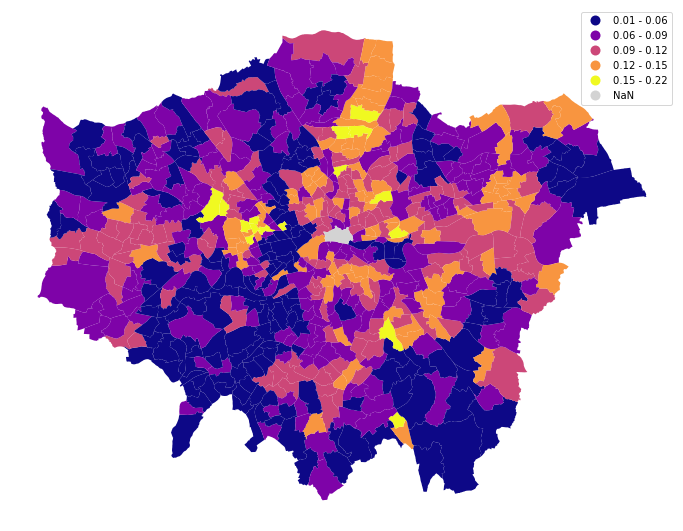

In [16]:
f, ax = plt.subplots(1, figsize=(12,10), facecolor = 'white')
ldnwards.plot(column='Employment score', scheme='natural_breaks', cmap = 'plasma', legend=True, ax=ax,
           missing_kwds= dict(color = "lightgrey",))
ax.axis('off')

In [17]:
import pysal as ps
import pysal.model.spreg as psms
from pysal.model.mgwr.sel_bw import Sel_BW
from pysal.model.mgwr.gwr import GWR

In [18]:
#remove nan columns - city of london
ldnwards2 = ldnwards[~ldnwards.yoy_TNO.isnull()]

In [19]:
ldnwards[ldnwards['Income score'].isnull()]

,NAME,GSS_CODE,HECTARES,NONLD_AREA,geometry,Population - 2015,Median Age - 2013,Area - Square Kilometres,Population density (persons per sq km) - 2013,% BAME - 2011,...,% Households Private Rented - 2011,Average Public Transport Accessibility score - 2014,Working age population,Income score,Employment score,IDACI score,IDAOPI score,TNO_apr20,TNO_apr19,yoy_TNO
632,Castle Baynard,E05009297,314.943,24.546,"POLYGON ((531361.303 180690.997, 531313.201 18...",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
#Coordinates for calibration points
def getXY(pt):
    return (pt.x, pt.y)
centroidseries = ldnwards2['geometry'].centroid
u,v = [list(t) for t in zip(*map(getXY, centroidseries))]

coords = list(zip(u,v))

In [21]:
y = ldnwards2['yoy_TNO'].values.reshape((-1,1))
X = ldnwards2[['Income score', 'Employment score',
       'IDACI score', 'IDAOPI score']].values

In [22]:
labels = ['Intercept','Income score', 'Employment score',
       'IDACI score', 'IDAOPI score']

In [23]:
y_norm = (y - y.mean(axis=0)) / y.std(axis=0)
X_norm = (X - X.mean(axis=0)) / X.std(axis=0)

In [24]:
m_ols = psms.OLS(y, X_norm, name_y='yoy_TNO',
              name_x=['Income score', 'Employment score',
       'IDACI score', 'IDAOPI score'])
print(m_ols.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :     yoy_TNO                Number of Observations:         632
Mean dependent var  :     -0.2505                Number of Variables   :           5
S.D. dependent var  :      0.2303                Degrees of Freedom    :         627
R-squared           :      0.1373
Adjusted R-squared  :      0.1318
Sum squared residual:      28.874                F-statistic           :     24.9448
Sigma-square        :       0.046                Prob(F-statistic)     :   3.448e-19
S.E. of regression  :       0.215                Log likelihood        :      78.385
Sigma-square ML     :       0.046                Akaike info criterion :    -146.770
S.E of regression ML:      0.2137                Schwarz criterion     :    -124.526

-----------------------------------------------------------------------------

In [25]:
bw = Sel_BW(coords, 
            y, # Independent variable
            X_norm, # Dependent variable
            fixed=False, # True for fixed bandwidth and false for adaptive bandwidth
            spherical=True) # Spherical coordinates (long-lat) or projected coordinates

In [26]:
bw.search()

629.0

In [27]:
model = GWR(coords, y_norm, X_norm, bw.bw[0])
results = model.fit()

In [28]:
results.summary()

Model type                                                         Gaussian
Number of observations:                                                 632
Number of covariates:                                                     5

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                            545.233
Log-likelihood:                                                    -850.103
AIC:                                                               1710.207
AICc:                                                              1712.341
BIC:                                                              -3498.221
R2:                                                                   0.137
Adj. R2:                                                              0.132

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [29]:
ldnwards3 = ldnwards2.copy()

In [30]:
filtered_estimates = results.filter_tvals(alpha=.99)
lastax = filtered_estimates.shape[1]

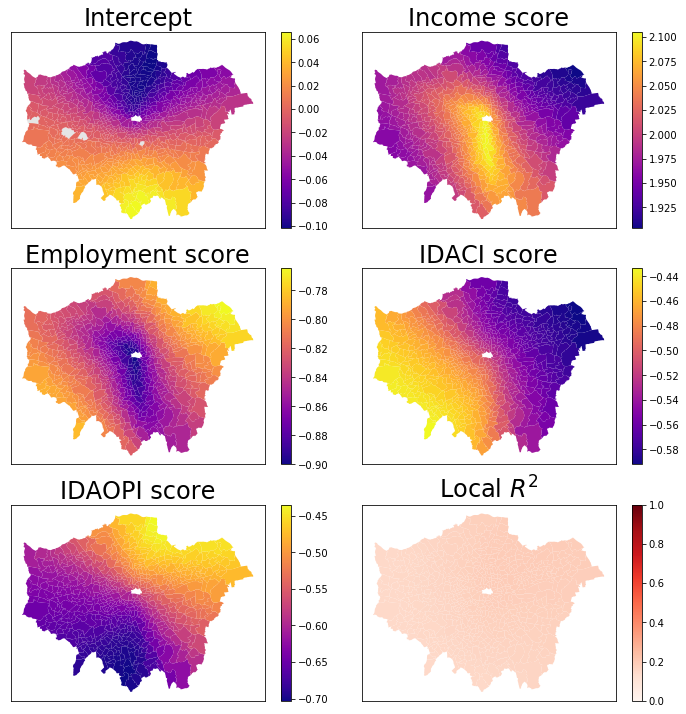

In [31]:
f, ax = plt.subplots(3,2, figsize=(10,10))

ax = ax.flatten()

for i,row in enumerate(filtered_estimates.T):
    listings_tmp = ldnwards3.assign(toplot = filtered_estimates.T[i])
    listings_tmp2 = listings_tmp.assign(params = results.params.T[i])
    
    listings_tmp2.query('toplot == 0')\
                .sort_values('toplot')\
                .plot(color = 'grey', ax = ax[i], alpha = .2)
    listings_tmp2.query('toplot != 0')\
                .sort_values('toplot')\
                .plot('params', cmap = 'plasma', ax = ax[i], legend = True)
    
    ax[i].set_title(labels[i], fontsize = 24)
    
    ax[i].set_xticklabels([])
    ax[i].set_yticklabels([])
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
ldnwards3.assign(r2 = results.localR2).sort_values('r2').\
            plot('r2', ax = ax[lastax], legend = True, cmap = 'Reds', vmin = 0, vmax = 1)
ax[lastax].set_xticklabels([])
ax[lastax].set_yticklabels([])
ax[lastax].set_xticks([])
ax[lastax].set_yticks([])

ax[lastax].set_title("Local $R^2$", fontsize = 24)


f.tight_layout()
plt.savefig('figures/covidcrimegwr.png')
plt.show()
    